In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_formats = ['svg']

In [4]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']
# matplotlib.rc('pdf', fonttype=42)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from brokenaxes import brokenaxes

'FreeSansBold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


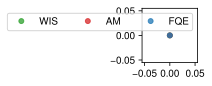

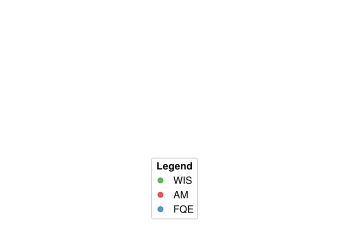

In [6]:
def export_legend(ax, filename="legend.pdf", expand=[-5,-5,5,5]):
    fig2 = plt.figure()
    ax2 = fig2.add_subplot()
    ax2.axis('off')
    legend = ax2.legend(*ax.get_legend_handles_labels(), frameon=True, loc='lower center', ncol=1, handlelength=1.0, title='Legend')
    legend.get_title().set_fontweight('bold')
    fig  = legend.figure
    fig.canvas.draw()
    
#     bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

fig, ax = plt.subplots(figsize=(1,1))
for i, (name, color, mark) in enumerate(zip(
    ['WIS', 'AM', 'FQE'],
    ['tab:green', 'tab:red', 'tab:blue'],
    ['o', 'd', '^']
)):
    plt.plot(0, 0, ls='None', c=color, marker='o', markersize=5, markeredgewidth=1, zorder=10, alpha=0.75, label=name)
plt.legend(ncol=3)
export_legend(plt.gca(), 'fig/plot-legend.pdf')

In [7]:
# Ground truth MDP model
MDP_parameters = joblib.load('../data/MDP_parameters.joblib')
P = MDP_parameters['transition_matrix_absorbing'] # (A, S, S_next)
R = MDP_parameters['reward_matrix_absorbing_SA'] # (S, A)
nS, nA = R.shape
gamma = 0.99

# unif rand isd, mixture of diabetic state
PROB_DIAB = 0.2
isd = joblib.load('../data/modified_prior_initial_state_absorbing.joblib')
isd = (isd > 0).astype(float)
isd[:720] = isd[:720] / isd[:720].sum() * (1-PROB_DIAB)
isd[720:] = isd[720:] / isd[720:].sum() * (PROB_DIAB)

# Optimal value function and optimal return
V_star = joblib.load('../data/V_π_star_PE.joblib')
J_star = V_star @ isd

In [8]:
num_runs = 5

In [9]:
min_regrets = [J_star - np.max(joblib.load('./results/run{}/sepsis-tab-1-tr.values.joblib'.format(run))['true_value_list']) for run in range(num_runs)]

## Exp 1

In [92]:
num_runs = 10

In [93]:
to_plot = 'Regret'

In [94]:
dfs_tr = [pd.read_csv('./results/run{}/sepsis-tab-1-tr.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va = [pd.read_csv('./results/run{}/sepsis-tab-1-va.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_trva = [pd.read_csv('./results/run{}/sepsis-tab-1-trva.csv'.format(run), index_col=0) for run in range(num_runs)]

In [95]:
regrets_tr = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_tr)], axis=1).T.drop(columns=['FQI'])
regrets_tr['Case'] = 'train'
regrets_va = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va)], axis=1).T.drop(columns=['FQI'])
regrets_va['Case'] = 'val'
regrets_trva = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_trva)], axis=1).T.drop(columns=['FQI'])
regrets_trva['Case'] = 'train val'

In [96]:
regrets_va.loc[1, 'WIS'] += 9e-4 # A hack to make points more discernable

In [97]:
regrets_exp1 = pd.concat([regrets_tr, regrets_va, regrets_trva])
regrets_exp1.columns.name = 'OPE'
regrets_exp1 = pd.DataFrame(regrets_exp1.set_index('Case').stack().rename(to_plot)).reset_index()

In [98]:
regrets_exp1 = regrets_exp1[regrets_exp1['OPE'].isin(['WIS', 'AM', 'FQE'])]

'FreeSansBold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


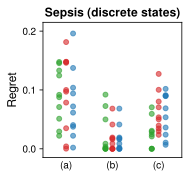

In [99]:
df = regrets_exp1.groupby(['Case', 'OPE']).agg(['min', 'median', 'max']).unstack()
df.columns = df.columns.droplevel()
df = df.loc[['train', 'val', 'train val']]
ncases, nlines = df.loc[:,'median'].shape

fig, ax = plt.subplots(figsize=(2.5, 2.5))
for i, (name, color, mark) in enumerate(zip(
    ['WIS', 'AM', 'FQE'],
    ['tab:green', 'tab:red', 'tab:blue'],
    ['o', 'd', '^']
)):
    yval, ylo, yhi = df.loc[:,('median', name)], df.loc[:,('min', name)], df.loc[:,('max', name)]
    yerrs = np.array([yval-ylo, yhi-yval])
    xpos = np.arange(ncases) + 0.15 * (i+0.5-nlines/2)
#     plt.errorbar(xpos, yval, yerr=yerrs, c=color, lw=0, elinewidth=1.25, ls='-', alpha=0.8)
#     plt.plot(xpos, yval, ls='None', c=color, marker=mark, markersize=6, zorder=10)
    
    yvals = regrets_exp1[regrets_exp1['OPE'] == name][to_plot].values.reshape((ncases, num_runs))
    plt.plot(xpos, yvals, ls='None', c=color, marker='o', markersize=5, markeredgewidth=1, zorder=10, alpha=0.6)


# plt.axhline(np.median(min_regrets), c='k')
# plt.axhspan(np.min(min_regrets), np.max(min_regrets), facecolor='gray', alpha=0.1)
# plt.ylim(0.2, 0.5)

ax.tick_params(axis='x', length=0)
plt.xlim(-0.5, 2.5)
plt.xticks([0,1,2], ['(a)', '(b)', '(c)'])
plt.ylim(-0.015, 0.215)
plt.yticks(np.arange(0, 0.25, 0.1))
# plt.xlabel('Split', fontsize=12)
plt.ylabel(to_plot, fontsize=12)
plt.title('Sepsis (discrete states)', fontsize=12, fontweight='bold')
plt.savefig('fig/sepsis-tab-exp1-tr_va.pdf', bbox_inches='tight')
plt.show()

## Exp 1a

In [84]:
num_runs = 10

In [85]:
to_plot = 'Suboptimality'

In [86]:
dfs_tr = [pd.read_csv('./results/run{}/sepsis-tab-1-tr.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va = [pd.read_csv('./results/run{}/sepsis-tab-1-va.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_trva = [pd.read_csv('./results/run{}/sepsis-tab-1-trva.csv'.format(run), index_col=0) for run in range(num_runs)]

In [87]:
regrets_tr = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_tr)], axis=1).T.drop(columns=['FQI'])
regrets_tr['Case'] = 'train'
regrets_va = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va)], axis=1).T.drop(columns=['FQI'])
regrets_va['Case'] = 'val'
regrets_trva = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_trva)], axis=1).T.drop(columns=['FQI'])
regrets_trva['Case'] = 'train val'

In [88]:
# regrets_va.loc[1, 'WIS'] += 9e-4 # A hack to make points more discernable

In [89]:
regrets_exp1a = pd.concat([regrets_tr, regrets_va, regrets_trva])
regrets_exp1a.columns.name = 'OPE'
regrets_exp1a = pd.DataFrame(regrets_exp1a.set_index('Case').stack().rename(to_plot)).reset_index()

In [90]:
regrets_exp1a = regrets_exp1a[regrets_exp1a['OPE'].isin(['WIS', 'AM', 'FQE'])]

'FreeSansBold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


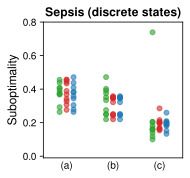

In [91]:
df = regrets_exp1a.groupby(['Case', 'OPE']).agg(['min', 'median', 'max']).unstack()
df.columns = df.columns.droplevel()
df = df.loc[['train', 'val', 'train val']]
ncases, nlines = df.loc[:,'median'].shape

fig, ax = plt.subplots(figsize=(2.5, 2.5))
for i, (name, color, mark) in enumerate(zip(
    ['WIS', 'AM', 'FQE'],
    ['tab:green', 'tab:red', 'tab:blue'],
    ['o', 'd', '^']
)):
    yval, ylo, yhi = df.loc[:,('median', name)], df.loc[:,('min', name)], df.loc[:,('max', name)]
    yerrs = np.array([yval-ylo, yhi-yval])
    xpos = np.arange(ncases) + 0.15 * (i+0.5-nlines/2)
#     plt.errorbar(xpos, yval, yerr=yerrs, c=color, lw=0, elinewidth=1.25, ls='-', alpha=0.8)
#     plt.plot(xpos, yval, ls='None', c=color, marker=mark, markersize=6, zorder=10)
    
    yvals = regrets_exp1a[regrets_exp1a['OPE'] == name][to_plot].values.reshape((ncases, num_runs))
    plt.plot(xpos, yvals, ls='None', c=color, marker='o', markersize=5, markeredgewidth=1, zorder=10, alpha=0.6)


# plt.axhline(np.median(min_regrets), c='k')
# plt.axhspan(np.min(min_regrets), np.max(min_regrets), facecolor='gray', alpha=0.1)
# plt.ylim(0.2, 0.5)

ax.tick_params(axis='x', length=0)
plt.xlim(-0.5, 2.5)
plt.xticks([0,1,2], ['(a)', '(b)', '(c)'])
plt.ylim(-0.01,0.8)
# plt.yticks(np.arange(0, 0.25, 0.1))
# plt.xlabel('Split', fontsize=12)
plt.ylabel(to_plot, fontsize=12)
plt.title('Sepsis (discrete states)', fontsize=12, fontweight='bold')
plt.savefig('fig/sepsis-tab-exp1a.pdf', bbox_inches='tight')
plt.show()

## Exp 2

In [26]:
num_runs = 10

In [27]:
to_plot = 'Regret'

In [28]:
dfs_va10k = [pd.read_csv('./results/run{}/sepsis-tab-1-va.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va5k = [pd.read_csv('./results/run{}/sepsis-tab-2-va5k.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va1k = [pd.read_csv('./results/run{}/sepsis-tab-2-va1k.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va500 = [pd.read_csv('./results/run{}/sepsis-tab-2-va500.csv'.format(run), index_col=0) for run in range(num_runs)]

In [29]:
regrets_va10k = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va10k)], axis=1).T.drop(columns=['FQI'])
regrets_va10k['Case'] = '10k'
regrets_va5k = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va5k)], axis=1).T.drop(columns=['FQI'])
regrets_va5k['Case'] = '5k'
regrets_va1k = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va1k)], axis=1).T.drop(columns=['FQI'])
regrets_va1k['Case'] = '1k'
regrets_va500 = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va500)], axis=1).T.drop(columns=['FQI'])
regrets_va500['Case'] = '500'

In [30]:
regrets_va10k.loc[1, 'WIS'] += 9e-4 # A hack to make points more discernable

In [31]:
regrets_exp2 = pd.concat([regrets_va500, regrets_va1k, regrets_va5k, regrets_va10k])
regrets_exp2.columns.name = 'OPE'
regrets_exp2 = pd.DataFrame(regrets_exp2.set_index('Case').stack().rename(to_plot)).reset_index()

In [32]:
regrets_exp2 = regrets_exp2[regrets_exp2['OPE'].isin(['WIS', 'AM', 'FQE'])]

'FreeSansBold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


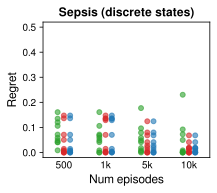

In [82]:
df = regrets_exp2.groupby(['Case', 'OPE']).agg(['min', 'median', 'max', 'mean']).unstack()
df.columns = df.columns.droplevel()
df = df.loc[['500', '1k', '5k', '10k']]
ncases, nlines = df.loc[:,'median'].shape

fig, ax = plt.subplots(figsize=(3, 2.5))
for i, (name, color, mark) in enumerate(zip(
    ['WIS', 'AM', 'FQE'],
    ['tab:green', 'tab:red', 'tab:blue'],
    ['o', 'd', '^']
)):
    xpos = np.arange(ncases) + 0.15 * (i+0.5-nlines/2)
    
    yval, ylo, yhi = df.loc[:,('median', name)], df.loc[:,('min', name)], df.loc[:,('max', name)]
#     yerrs = np.array([yval-ylo, yhi-yval])
#     plt.errorbar(xpos, yval, yerr=yerrs, c=color, lw=0, elinewidth=0.8, ls='-', alpha=0.8)
#     plt.plot(xpos, yhi, ls='-', c=color, marker='_', markersize=6, zorder=10)
#     plt.plot(xpos, yval, ls='None', c=color, marker=mark, markersize=6, zorder=10)
#     ymean = df.loc[:,('mean', name)]
#     plt.plot(xpos, ymean, ls='-', c=color, marker='_', markersize=6, zorder=10)
    
    yvals = regrets_exp2[regrets_exp2['OPE'] == name][to_plot].values.reshape((ncases, num_runs))
    plt.plot(xpos, yvals, ls='None', c=color, marker='o', markersize=5, markeredgewidth=1, zorder=10, alpha=0.6)

plt.xlim(-0.5, 3.5)
ax.tick_params(axis='x', length=0)
plt.xticks([0,1,2,3], ['500', '1k', '5k', '10k'])
plt.ylim(-0.005, 0.205)
plt.ylim(-0.02, 0.52)
# plt.yticks(np.arange(0, 0.25, 0.1))
plt.xlabel('Num episodes', fontsize=12)
plt.ylabel(to_plot, fontsize=12)
plt.title('Sepsis (discrete states)', fontsize=12, fontweight='bold')
plt.savefig('fig/sepsis-tab-exp2-size.pdf', bbox_inches='tight')
plt.show()

## Exp 3

In [34]:
num_runs = 10

In [35]:
to_plot = 'Regret'

In [36]:
dfs_va10k = [pd.read_csv('./results/run{}/sepsis-tab-1-va.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va10k_eps01 = [pd.read_csv('./results/run{}/sepsis-tab-3-va10k_eps01.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va10k_mixed = [pd.read_csv('./results/run{}/sepsis-tab-3-va10k_mixed.csv'.format(run), index_col=0) for run in range(num_runs)]

In [37]:
regrets_va10k = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va10k)], axis=1).T.drop(columns=['FQI'])
regrets_va10k['Case'] = 'Random'
regrets_va10k_eps01 = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va10k_eps01)], axis=1).T.drop(columns=['FQI'])
regrets_va10k_eps01['Case'] = 'ε-greedy'
regrets_va10k_mixed = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va10k_mixed)], axis=1).T.drop(columns=['FQI'])
regrets_va10k_mixed['Case'] = 'Mixed'

In [38]:
regrets_exp3 = pd.concat([regrets_va10k, regrets_va10k_mixed, regrets_va10k_eps01])
regrets_exp3.columns.name = 'OPE'
regrets_exp3 = pd.DataFrame(regrets_exp3.set_index('Case').stack().rename(to_plot)).reset_index()

In [39]:
regrets_exp3 = regrets_exp3[regrets_exp3['OPE'].isin(['WIS', 'AM', 'FQE'])]

'FreeSansBold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


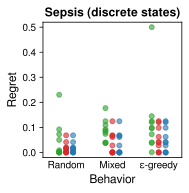

In [81]:
df = regrets_exp3.groupby(['Case', 'OPE']).agg(['min', 'median', 'max']).unstack()
df.columns = df.columns.droplevel()
df = df.loc[['Random', 'Mixed', 'ε-greedy']]
ncases, nlines = df.loc[:,'median'].shape

fig, ax = plt.subplots(figsize=(2.5, 2.5))
for i, (name, color, mark) in enumerate(zip(
    ['WIS', 'AM', 'FQE'],
    ['tab:green', 'tab:red', 'tab:blue'],
    ['o', 'd', '^']
)):
    yval, ylo, yhi = df.loc[:,('median', name)], df.loc[:,('min', name)], df.loc[:,('max', name)]
    yerrs = np.array([yval-ylo, yhi-yval])
    xpos = np.arange(ncases) + 0.15 * (i+0.5-nlines/2)
#     plt.errorbar(xpos, yval, yerr=yerrs, c=color, lw=1.75, elinewidth=0.8, ls='-', alpha=0.8)
#     plt.plot(xpos, yval, ls='None', c=color, marker=mark, markersize=6, zorder=10)

    yvals = regrets_exp3[regrets_exp3['OPE'] == name][to_plot].values.reshape((ncases, num_runs))
    plt.plot(xpos, np.clip(yvals,0,0.5), ls='None', c=color, marker='o', markersize=5, markeredgewidth=1, zorder=10, alpha=0.6, clip_on=False)

# plt.axhline(np.median(min_regrets), c='k')
# plt.axhspan(np.min(min_regrets), np.max(min_regrets), facecolor='gray', alpha=0.1)
# plt.ylim(0.2, 0.5)
plt.ylim(-0.02, 0.52)
plt.xlim(-0.5, 2.5)

ax.tick_params(axis='x', length=0)
plt.xticks([0,1,2], ['Random', 'Mixed', 'ε-greedy'])
# plt.yticks(np.arange(0, 0.3, 0.1))
plt.xlabel('Behavior', fontsize=12)
plt.ylabel(to_plot, fontsize=12)
plt.title('Sepsis (discrete states)', fontsize=12, fontweight='bold')
plt.savefig('fig/sepsis-tab-exp3-behavior.pdf', bbox_inches='tight')
plt.show()

## Exp 4

In [41]:
num_runs = 10

In [42]:
to_plot = 'Regret'

In [63]:
L_list = [1, 5, 10, 20, 50, 100]
df_FQE_L = [pd.read_csv('./results/run{}/sepsis-tab-4-FQE_L.csv'.format(run), index_col=0) for run in range(num_runs)]
regrets_FQE_L = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(df_FQE_L)], axis=1).T
regrets_FQE_L.columns = L_list
regrets_FQE_L.columns.name = 'FQE (H)'
regrets_FQE_L = regrets_FQE_L.drop(columns=[1])
L_list = L_list[1:]

In [64]:
regrets_FQE_L.loc[[6], [20,50,100]] += 9e-4 # A hack to make points more discernable
regrets_FQE_L.loc[[8], [20,50,100]] += 1e-3 # A hack to make points more discernable

'FreeSansBold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


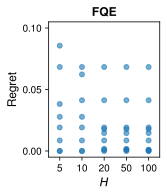

In [66]:
df = regrets_FQE_L.agg(['min', 'median', 'max'])
color = 'tab:blue'
mark = '^'
_, ncases = df.shape

fig, ax = plt.subplots(figsize=(2,2.5))
yval, ylo, yhi = df.loc['median'], df.loc['min'], df.loc['max']
yerrs = np.array([yval-ylo, yhi-yval])
xpos = np.arange(ncases)
# plt.errorbar(xpos, yval, yerr=yerrs, c=color, lw=1.75, elinewidth=0.8, capsize=3, ls='-', alpha=0.8)
# plt.plot(xpos, yval, ls='None', c=color, marker=mark, markersize=5, zorder=10)

yvals = regrets_FQE_L.T
plt.plot(xpos, yvals, ls='None', c=color, marker='o', markersize=5, markeredgewidth=1, zorder=10, alpha=0.6)

# plt.axhline(np.median(min_regrets), c='k')
# plt.axhspan(np.min(min_regrets), np.max(min_regrets), facecolor='gray', alpha=0.1)
# plt.ylim(0.2, 0.45)
plt.ylim(-0.005, 0.105)
plt.yticks(np.arange(0, 0.11, 0.05))

# ax.tick_params(axis='x', length=0)
plt.xticks(range(len(L_list)), L_list)
plt.xlim(-0.5, 4.5)
plt.xlabel('$H$', fontsize=12)
plt.ylabel(to_plot, fontsize=12)
plt.title('FQE', fontsize=12, fontweight='bold')
plt.savefig('fig/sepsis-tab-exp4-FQE_L.pdf', bbox_inches='tight')
plt.show()

In [77]:
eps_list = [0, 0.01, 0.05, 0.10, 0.50, 1]
df_WIS_eps = [pd.read_csv('./results/run{}/sepsis-tab-4-WIS_eps.csv'.format(run), index_col=0) for run in range(num_runs)]
regrets_WIS_eps = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(df_WIS_eps)], axis=1).T
regrets_WIS_eps.columns = eps_list
regrets_WIS_eps.columns.name = 'WIS (eps)'
regrets_WIS_eps = regrets_WIS_eps.drop(columns=[1])
eps_list = eps_list[:-1]

In [78]:
regrets_WIS_eps.loc[[1], [0, 0.01]] += 9e-4 # A hack to make points more discernable
regrets_WIS_eps.loc[[3], [0.05, 0.1]] += 11e-4
regrets_WIS_eps.loc[[6], [0, 0.01, 0.05, 0.1]] += 12e-4
regrets_WIS_eps.loc[[8], [0, 0.01, 0.05, 0.1]] += 13e-4

'FreeSansBold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


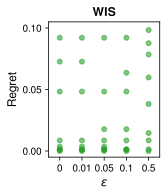

In [80]:
df = regrets_WIS_eps.agg(['min', 'median', 'max'])
color = 'tab:green'
mark = 'o'
_, ncases = df.shape

fig, ax = plt.subplots(figsize=(2,2.5))
yval, ylo, yhi = df.loc['median'], df.loc['min'], df.loc['max']
yerrs = np.array([yval-ylo, yhi-yval])
# xpos = eps_list
xpos = np.arange(ncases)
# plt.errorbar(xpos, yval, yerr=yerrs, c=color, lw=1.75, elinewidth=0.8, capsize=3, ls='-', alpha=0.8)
# plt.plot(xpos, yval, ls='None', c=color, marker=mark, markersize=5, zorder=10)

yvals = regrets_WIS_eps.T
plt.plot(xpos, yvals, ls='None', c=color, marker='o', markersize=5, markeredgewidth=1, zorder=10, alpha=0.6)

# plt.axhline(np.median(min_regrets), c='k')
# plt.axhspan(np.min(min_regrets), np.max(min_regrets), facecolor='gray', alpha=0.1)
# plt.ylim(0.2, 0.45)
plt.ylim(-0.005, 0.105)
plt.yticks(np.arange(0, 0.11, 0.05))

# ax.tick_params(axis='x', length=0)
# plt.xscale('symlog', linthresh=0.01)
# plt.xticks(eps_list, eps_list)
# plt.xlim(-0.001, 1.15)
plt.xticks(range(len(eps_list)), eps_list)
plt.xlim(-0.5, 4.5)
plt.xlabel('$\epsilon$', fontsize=12)
plt.ylabel(to_plot, fontsize=12)
plt.title('WIS', fontsize=12, fontweight='bold')
plt.savefig('fig/sepsis-tab-exp4-WIS_eps.pdf', bbox_inches='tight')
plt.show()